# Frozen Lake


#### Import all requirements

In [1]:
import gym
import numpy as np
import random
import torch
import time
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
og_4x4 = ['SFFF',
'FHFH',
'HFFH',
'HFFG']



In [3]:

env = gym.make('FrozenLake-v0', is_slippery=False, desc = og_4x4)


# visualize 4x4 frozen lake
env.render()


SFFF
FHFH
HFFH
HFFG


In [4]:
# Total number of States and Actions
n_states = env.observation_space.n
n_actions = env.action_space.n
n_rows = 4
n_cols = 4
print( "States = ", n_states)
print( "Actions = ", n_actions)

States =  16
Actions =  4


In [7]:
def restrict_actions(Q, n_states, n_rows):

  Q.at[n_states -1, :] = np.zeros(n_rows,)
  for i in range( 0, n_states, n_rows): 
    Q.at[i,0] = np.NaN
  for i in range( n_rows -1 , n_states, n_rows): 
    Q.at[i,2] = np.NaN
  for i in range(0, n_rows):
    Q.at[i,3] = np.NaN
  for i in range(n_states - n_rows , n_states):
    Q.at[i,1 ]= np.NaN
  
  return Q
  

In [65]:
def choose_action(Q, state, epsilon):
  random_for_epsilon = np.random.rand()
  if random_for_epsilon <= epsilon:
    s = Q.loc[state].notna()
    vals = s[s].index.values
    action = random.choice(vals)
  else: 
   action = np.argmax(Q.loc[state])
  return action

In [10]:
##assign index to each state using state-matrix

state_matrix = np.arange(0,n_states).reshape(n_rows,n_cols)
state_matrix

def rowsandcols(state):
  ''' input: state returned by env
      output: location of state as (row,col) tuple'''
  return int(np.where(state_matrix ==state)[0]), int(np.where(state_matrix ==state)[1])

In [33]:
def rewarder(new_state, reward):
  if og_4x4[rowsandcols(new_state)[0]][rowsandcols(new_state)[1]]== 'H':
    reward -= 20
  elif og_4x4[rowsandcols(new_state)[0]][rowsandcols(new_state)[1]]== 'F':
    reward -= 1 
  elif og_4x4[rowsandcols(new_state)[0]][rowsandcols(new_state)[1]]== 'S':
    reward -= 1
  else: #goal
    reward += 100

  return reward

In [66]:
# Start with 80% random actions to explore the environment
# exploration decays with each timestep by a factor of 0.999 until it hits 10% exploration rate 

epsilon = 0.8
epsilon_final = 0.1
epsilon_decay = 0.99

In [67]:
gamma = 0.90 # discount factor
learning_rate = 0.9 #how important is the difference between q-val from q-table and what's observed

#### Initialize Q-table

In [68]:
Q = pd.DataFrame(np.random.rand(n_states,n_actions)/100)
Q.loc[n_states-1] = np.zeros(n_actions,)
#Q = restrict_actions(Q, n_states, n_rows)
Q

,0,1,2,3
0,0.002987,0.003661,0.001682,0.007429
1,0.009462,0.009364,0.004785,0.001078
2,0.001636,0.002033,0.000088,0.009093
3,0.003676,0.007124,0.000069,0.006800
4,0.000416,0.004342,0.008815,0.007963
5,0.001973,0.003194,0.001385,0.009546
6,0.001662,0.004636,0.004349,0.002962
7,0.002686,0.007100,0.001386,0.006004
8,0.003124,0.000138,0.009522,0.007164
9,0.008796,0.002600,0.007984,0.003421


In [69]:
num_episodes = 1000
steps_total = [] # store number of steps taken in each episode
rewards_total = [] #store reward obtained for each episode
epsilon_total = [] #store epsilon obtained at the end of each episode
terminal_state = []

## q learning

In [70]:
for i_episode in range(num_episodes):
    
    # resets the environment
    state = env.reset()
    step = 0
    reward = 0

  ## as epsilon decays with more timesteps, the prob. of selecting a random val < e decays --> more likely to exploit. 
    if epsilon > epsilon_final:
            epsilon *= epsilon_decay

    while True:
        
        step += 1
        
        random_for_epsilon = np.random.rand()
        if random_for_epsilon <= epsilon:
          action = env.action_space.sample()
        else: 
          action = np.argmax(Q.loc[state])
  
         
        ## env gives reward and next state and whether we've reached terminal state upon taking action at current state.. 
        new_state, _ , done, info = env.step(action)

        ##if you want reward penalized at for each timestep
        reward = rewarder(new_state, reward)
        
          
        

        # filling the Q Table - 
        
        Q.loc[state, action] = (1- learning_rate)*Q.at[state, action] + learning_rate*(reward + gamma * np.max(Q.loc[new_state]))
        
        # Setting new state for next action
        state = new_state
        tile = og_4x4[rowsandcols(state)[0]][rowsandcols(state)[1]]
        #env.render()
        
        if done:
          #print(Q)
          
          terminal_state.append(tile)
          steps_total.append(step)
          rewards_total.append(reward)
          epsilon_total.append(epsilon)
          if i_episode % 10 == 0:
            print('Episode: {} Reward: {} Steps Taken: {} Terminal State: {}, Epsilon: {}'.format(i_episode,reward, step, tile, epsilon))
          break


Episode: 0 Reward: -24 Steps Taken: 5 Terminal State: H, Epsilon: 0.792
Episode: 10 Reward: -26 Steps Taken: 7 Terminal State: H, Epsilon: 0.7162706034069731
Episode: 20 Reward: -27 Steps Taken: 8 Terminal State: H, Epsilon: 0.6477822945770066
Episode: 30 Reward: -32 Steps Taken: 13 Terminal State: H, Epsilon: 0.5858426957235178
Episode: 40 Reward: -28 Steps Taken: 9 Terminal State: H, Epsilon: 0.5298256327871866
Episode: 50 Reward: 95 Steps Taken: 6 Terminal State: G, Epsilon: 0.4791648051729288
Episode: 60 Reward: -31 Steps Taken: 12 Terminal State: H, Epsilon: 0.4333480607734829
Episode: 70 Reward: 93 Steps Taken: 8 Terminal State: G, Epsilon: 0.391912218403364
Episode: 80 Reward: 93 Steps Taken: 8 Terminal State: G, Epsilon: 0.35443838530093813
Episode: 90 Reward: 88 Steps Taken: 13 Terminal State: G, Epsilon: 0.3205477223612326
Episode: 100 Reward: 93 Steps Taken: 8 Terminal State: G, Epsilon: 0.2898976142883978
Episode: 110 Reward: -23 Steps Taken: 4 Terminal State: H, Epsilon: 0

In [71]:
Q

,0,1,2,3
0,37.431195,33.088289,43.355171,37.967139
1,34.862746,-20.991679,49.956111,42.173841
2,37.829769,55.650330,39.108830,49.667005
3,47.014914,-25.694882,31.721650,26.007338
4,29.287258,-21.378457,-22.189751,37.853316
5,0.001973,0.003194,0.001385,0.009546
6,-23.261499,65.597649,-22.993632,48.319184
7,0.002686,0.007100,0.001386,0.006004
8,0.003124,0.000138,0.009522,0.007164
9,-26.541428,60.694320,65.039746,-34.281461


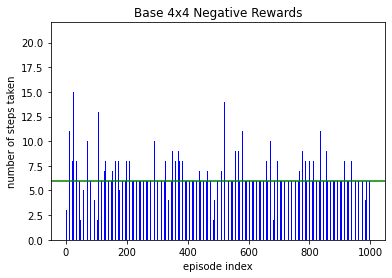

In [72]:
plt.axhline(y=6, color='green', linestyle='-')
plt.bar(np.arange(0, 1000), steps_total, 
        width = 0.4, color = 'blue')
plt.xlabel('episode index')
plt.ylabel('number of steps taken')
plt.title('Base 4x4 Negative Rewards')
plt.show()

Text(0, 0.5, 'reward')

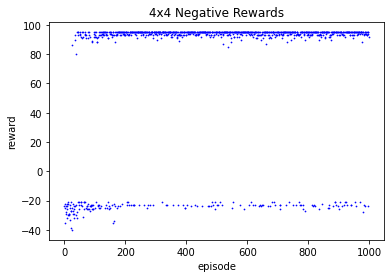

In [73]:

plt.scatter(np.arange(0, 1000), rewards_total, s = 0.5, color = 'blue')
plt.title('4x4 Negative Rewards')
plt.xlabel('episode')
plt.ylabel('reward')

In [ ]:
Q

,0,1,2,3
0,9.687764,14.818251,7.088224,12.058932
1,11.362684,-5.995770,-14.754873,-12.037507
2,-9.135922,-17.731013,-14.001078,-21.437789
3,-21.617321,-11.610763,-17.989366,-17.340240
4,10.821792,17.850792,-5.983707,5.469555
5,0.000000,0.000000,0.000000,0.000000
6,-15.292364,25.648473,-16.340385,-19.544755
7,0.000000,0.000000,0.000000,0.000000
8,11.238300,-7.177370,22.141840,11.744492
9,12.683235,24.351699,27.949154,-7.984162


NameError: ignored